In [26]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import pandas as pd
import numpy as np
from datetime import timedelta,date, time
from matplotlib import pyplot as plt

### Loading weather data marked with height and water input information

In [28]:
df = pd.read_csv('../data/interim/roseg_measurements.csv', parse_dates=['time'])
del df['doy']
df.head()

,time,temp,rh,ws,height,water
0,2016-11-17 14:00:00,3.43,68.98,1.67,5.378824,1.0
1,2016-11-17 16:00:00,-0.83,89.60,0.34,5.507915,1.0
2,2016-11-18 10:00:00,4.74,53.88,2.29,5.400339,1.0
3,2016-11-18 12:00:00,4.56,56.59,2.42,5.540188,1.0
4,2016-11-18 14:00:00,1.07,86.50,3.32,5.529431,1.0


Calculating Growth Rate which is the rate of change in height(cm/hr)

In [29]:
df['delta_time'] = (df['time']-df['time'].shift()).fillna(0)
df['delta_height'] = (df['height']-df['height'].shift()).fillna(0)
df['growth_rate'] = (df['delta_height']*100)/(df['delta_time'].apply(lambda x: x.total_seconds()/3600))

### Loading all weather records 

In [30]:
dfb = pd.read_csv('../data/interim/roseg_data.csv', parse_dates=['time'])
dfb.set_index('time', inplace=True)
dfb.head()

,doy,temp,rh,ws
time,,,,
2016-11-17 17:00:00,322,5.83,56.46,0.47
2016-11-17 18:00:00,322,5.68,55.99,0.85
2016-11-17 13:00:00,322,5.02,63.64,1.65
2016-11-17 14:00:00,322,3.43,68.98,1.67
2016-11-17 15:00:00,322,2.08,79.00,0.91


In [31]:
print('Weather Data contains %d records' % len(dfb))

Weather Data contains 5571 records


In [32]:
df = df[['time', 'temp', 'height', 'growth_rate','water']].copy()

### Defining additional features
Just correlating the data to the Temperature, wind speed and humidity might not capture the variation in growth rate. Adding average temperature, humidity and Wind Speed values over the past 12 hours might be useful.

In [33]:
df['temp_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].mean())
df['temp_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].count())

df['rh_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].mean())
df['rh_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].count())

df['ws_12h_avg'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].mean())
df['ws_12h_count'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].count())

Filtering records for which averages are calculated over less than 5 values over the past 12 hours

In [34]:
df = df[(df[[col for col in df.columns if col.endswith('count')]]>=5).all(axis='columns')]
df = df[[col for col in df.columns if not col.endswith('count')]]

In [35]:
df['type'] = df['time'].apply(lambda x: 'AM' if x.time()<datetime.time(12) else 'PM')

### Final Cleaning

In [36]:
df.dropna(inplace=True)
df.head()

,time,temp,height,growth_rate,water,temp_12h_avg,rh_12h_avg,ws_12h_avg,type
2,2016-11-18 10:00:00,4.74,5.400339,-0.597647,1.0,-2.213077,80.690769,1.138462,AM
3,2016-11-18 12:00:00,4.56,5.540188,6.992471,1.0,-1.043077,75.166154,1.500769,PM
4,2016-11-18 14:00:00,1.07,5.529431,-0.537882,1.0,0.080769,73.766154,1.866923,PM
5,2016-11-19 10:00:00,0.69,5.432612,-0.484094,1.0,0.124615,97.361538,1.115385,AM
6,2016-11-19 12:00:00,1.68,5.443369,0.537882,1.0,0.331538,95.869231,1.280000,PM


### Correlation/linear regression plots
With all the data loaded and features defined, lets plot all the features and estimate their linear relationship to growth rate

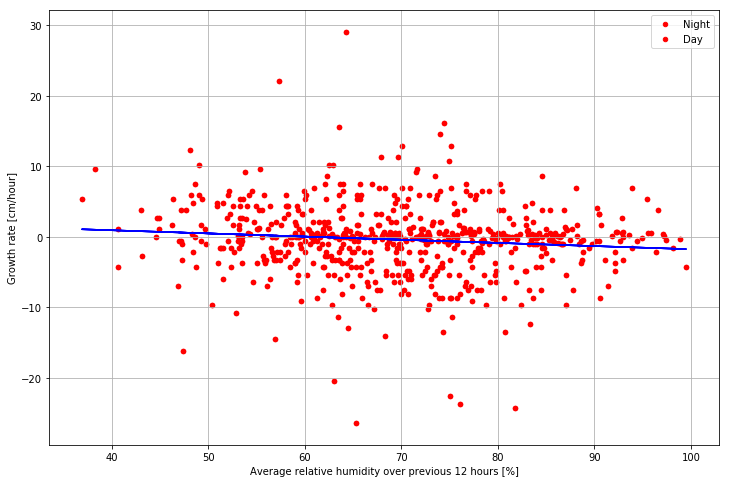

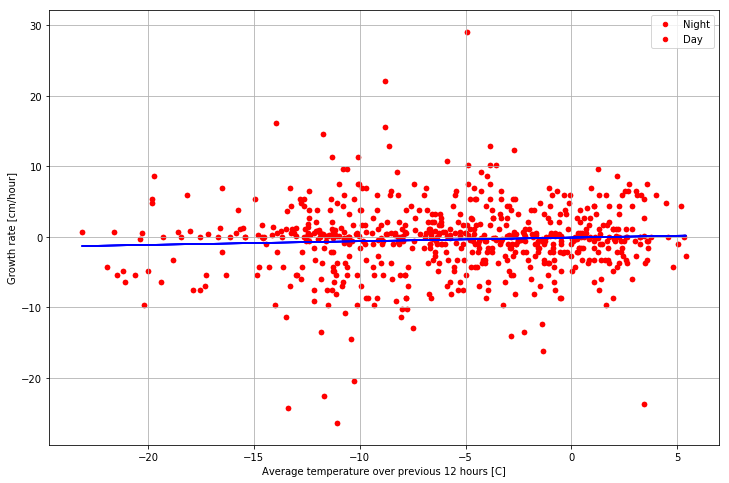

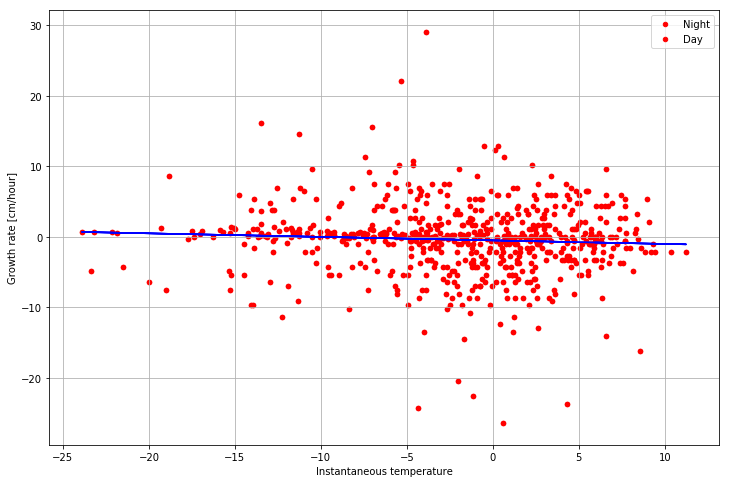

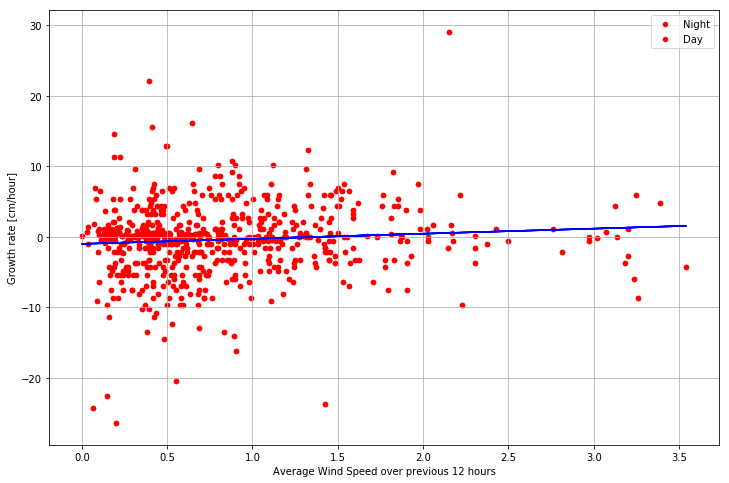

In [37]:
var_dict = {'temp': 'Instantaneous temperature',
            'temp_12h_avg': 'Average temperature over previous 12 hours [C]',
            'ws_12h_avg': 'Average Wind Speed over previous 12 hours',
            'rh_12h_avg': 'Average relative humidity over previous 12 hours [%]'}
for var in var_dict:
    fig=plt.figure(figsize=(12,8))
    ax=fig.add_subplot(1,1,1)
    for mtype in [('AM', 'Night', 'b'), ('PM', 'Day', 'r')]:
        dftmp = df
        dftmp.plot(x=var, y='growth_rate', kind='scatter', ax=ax, label=mtype[1], color='r')
        plt.plot(dftmp[var], np.poly1d(np.polyfit(dftmp[var], dftmp['growth_rate'], 1))(dftmp[var]),
                 color='b')
    plt.grid()
    ax.set_xlabel(var_dict[var])
    ax.set_ylabel('Growth rate [cm/hour]')
    plt.show();

As most of the freezing happens in the night and the melt in the day. Let's classify data points as night and day points

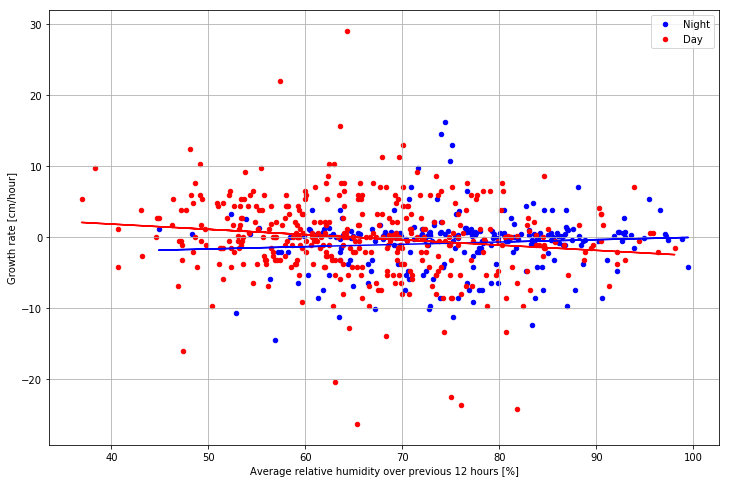

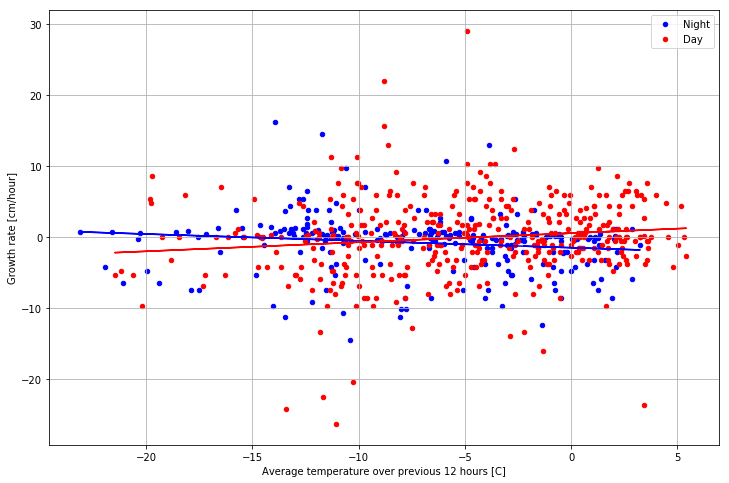

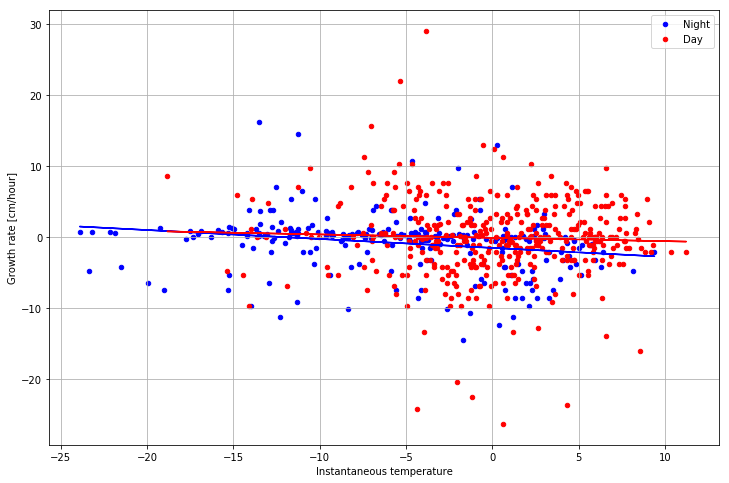

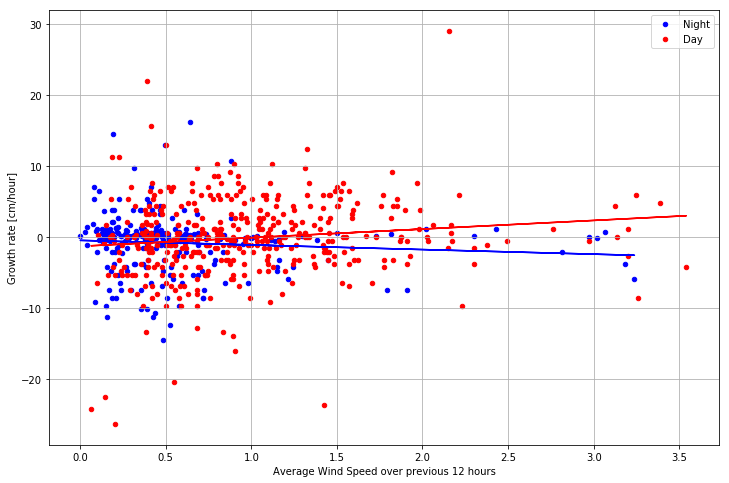

In [38]:
for var in var_dict:
    fig=plt.figure(figsize=(12,8))
    ax=fig.add_subplot(1,1,1)
    for mtype in [('AM', 'Night', 'b'), ('PM', 'Day', 'r')]:
        dftmp = df[(df['type']==mtype[0])]
        dftmp.plot(x=var, y='growth_rate', kind='scatter', ax=ax, label=mtype[1], color=mtype[2])
        plt.plot(dftmp[var], np.poly1d(np.polyfit(dftmp[var], dftmp['growth_rate'], 1))(dftmp[var]),
                 color=mtype[2])
    plt.grid()
    ax.set_xlabel(var_dict[var])
    ax.set_ylabel('Growth rate [cm/hour]')
    plt.show();

Indeed there is a marked change in behoviour during the night and day periods. But there were also lot of periods when the fountain was not functioning. Lets remove these data points next.

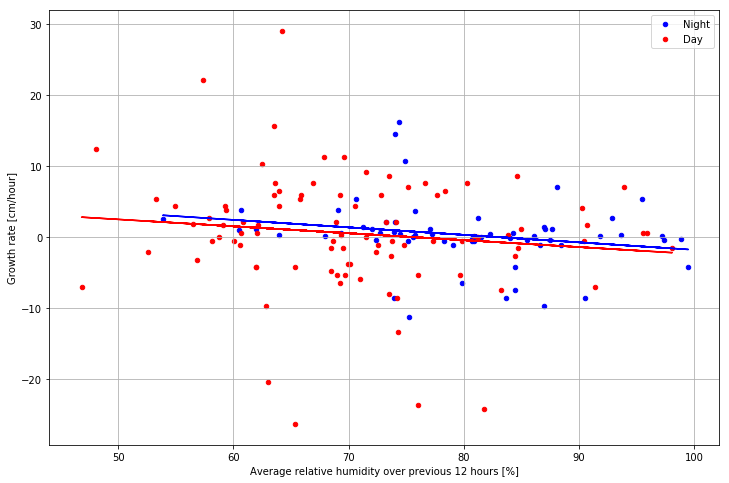

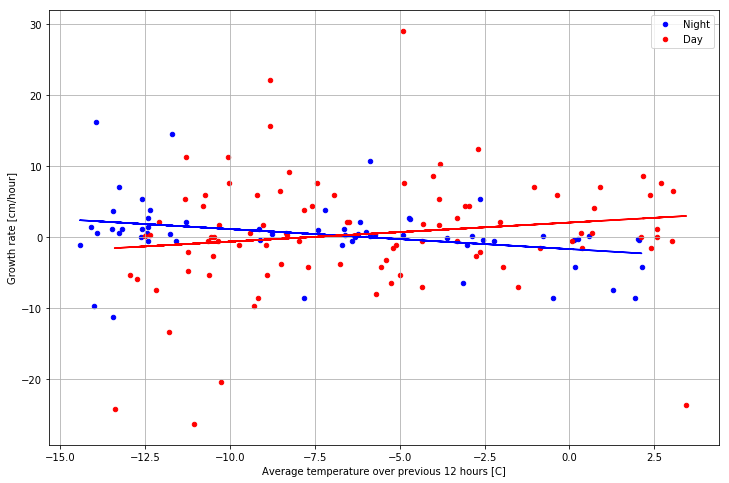

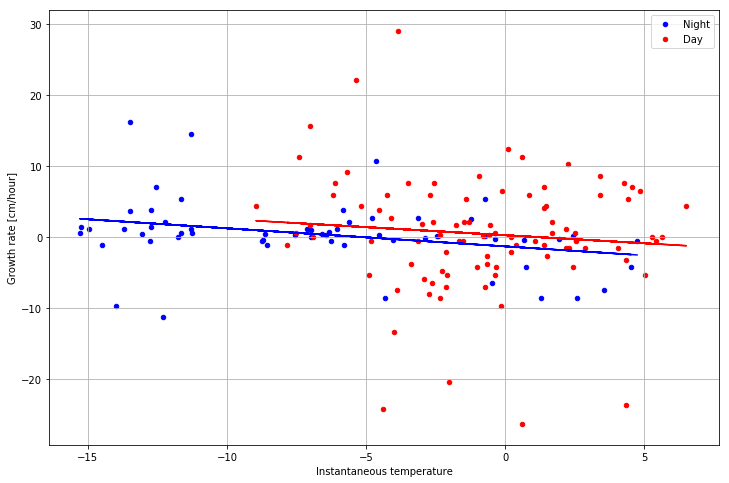

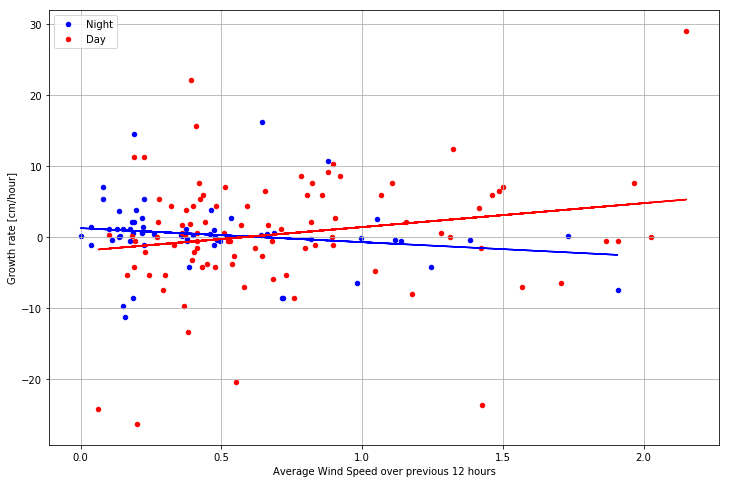

In [39]:
for var in var_dict:
    fig=plt.figure(figsize=(12,8))
    ax=fig.add_subplot(1,1,1)
    for mtype in [('AM', 'Night', 'b'), ('PM', 'Day', 'r')]:
        dftmp = df[(df['type']==mtype[0]) & (df['water'])==1]
        dftmp.plot(x=var, y='growth_rate', kind='scatter', ax=ax, label=mtype[1], color=mtype[2])
        plt.plot(dftmp[var], np.poly1d(np.polyfit(dftmp[var], dftmp['growth_rate'], 1))(dftmp[var]),
                 color=mtype[2])
    plt.grid()
    ax.set_xlabel(var_dict[var])
    ax.set_ylabel('Growth rate [cm/hour]')
    plt.show();

Seems like most of the growth rate records below 10 have dissapeared and so were recorded when the fountain was not functioning. So most growth rates below 10 were due to natural melt and precipitation. Lets analyse all the outliers then.

### Multivariate linear regression
We want to know how the growth rate depends on the predictors we measured, and to what extent a linear combination of these predictors alone can explain the observed growth rate.

We will use elastic net regularisation, which has the advantage of doing feature selection and accounting for collinearity between predictors. This allows us to add new features to the model selection workflow and select the relevant ones.

In [41]:
print('%d morning measurements' % len(df[df['type']=='AM']))
print('%d evening measurements' % len(df[df['type']=='PM']))

246 morning measurements
408 evening measurements


We will model separately the growth and the melt process, as they have different dynamics and depend on different parameters. In addition, our data set is so small that it won't make sense to do cross-validation, so there's nothing wrong with scoring (testing) on the training set.

In [42]:
from sklearn.linear_model import ElasticNet
model = ElasticNet()

In [43]:
X = df[df['type']=='AM'][['temp_12h_avg', 'rh_12h_avg', 'ws_12h_avg']]
y = df[df['type']=='AM']['growth_rate']
model.fit(X,y)
print('Morning observations: R-squared = %0.2f' % model.score(X,y))

X = df[df['type']=='PM'][['temp_12h_avg', 'rh_12h_avg', 'ws_12h_avg']]
y = df[df['type']=='PM']['growth_rate']
model.fit(X,y)
print('Evening observations: R-squared = %0.2f' % model.score(X,y))

Morning observations: R-squared = 0.03
Evening observations: R-squared = 0.04



Rather poor performance in both cases -- let's add additional features created from the same time series

In [44]:
df['temp_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].min())
df['temp_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].max())
df['temp_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].std())

df['rh_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].min())
df['rh_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].max())
df['rh_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].std())

df['ws_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].min())
df['ws_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].max())
df['ws_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].std())

In [45]:
model_am = ElasticNet()
model_pm = ElasticNet()
X_am = df[df['type']=='AM'][[col for col in df.columns if (col.startswith('temp')
                                                           or col.startswith('rh')
                                                           or col.startswith('uv')
                                                          )]]
y_am = df[df['type']=='AM']['growth_rate']
model_am.fit(X_am,y_am)
print('Morning observations: R-squared = %0.2f' % model_am.score(X_am,y_am))

X_pm = df[df['type']=='PM'][[col for col in df.columns if (col.startswith('temp')
                                                            or col.startswith('rh')
                                                            or col.startswith('uv')
                                                           )]]
y_pm = df[df['type']=='PM']['growth_rate']
model_pm.fit(X_pm,y_pm)
print('Morning observations: R-squared = %0.2f' % model_pm.score(X_pm,y_pm))

Morning observations: R-squared = 0.06
Morning observations: R-squared = 0.11


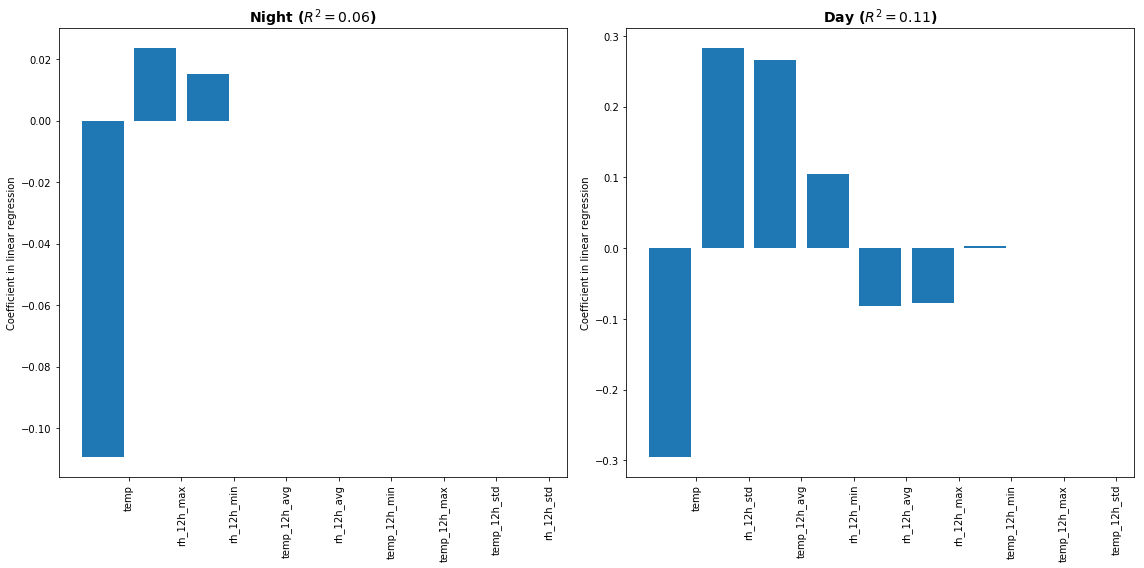

In [46]:
fig=plt.figure(figsize=(16,8))

# getting unzipped lists of feature names and corresponding coefficients, sorted by absolute decreasing coefficient
features_am, weights_am = zip(*sorted(zip(X_am.columns, model_am.coef_), key=lambda x: abs(x[1]), reverse=True))
features_pm, weights_pm = zip(*sorted(zip(X_pm.columns, model_pm.coef_), key=lambda x: abs(x[1]), reverse=True))

ax=fig.add_subplot(1,2,1)
plt.bar(range(len(weights_am)), weights_am)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_am))], features_am, rotation='vertical')
ax.set_title('Night ($R^2=%0.2f$)' % model_am.score(X_am,y_am), {'fontsize': 14, 'fontweight' : 'bold'})

ax=fig.add_subplot(1,2,2)
plt.bar(range(len(weights_pm)), weights_pm)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_pm))], features_pm, rotation='vertical')
ax.set_title('Day ($R^2=%0.2f$)' % model_pm.score(X_pm,y_pm), {'fontsize': 14, 'fontweight' : 'bold'}) 

plt.tight_layout()
plt.show()

### Restricting analysis to periods of fountain operation

In [47]:
df=df[df['water']==1]
print('%d morning measurements' % len(df[df['type']=='AM']))
print('%d evening measurements' % len(df[df['type']=='PM']))

61 morning measurements
94 evening measurements


In [48]:
df['temp_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].min())
df['temp_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].max())
df['temp_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['temp'].std())

df['rh_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].min())
df['rh_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].max())
df['rh_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['rh'].std())

df['ws_12h_min'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].min())
df['ws_12h_max'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].max())
df['ws_12h_std'] = df['time'].apply(lambda x: dfb[(dfb.index<=x) & (dfb.index>=(x-timedelta(hours=12)))]['ws'].std())

In [49]:
model_am = ElasticNet()
model_pm = ElasticNet()
X_am = df[df['type']=='AM'][[col for col in df.columns if (col.startswith('temp')
                                                           or col.startswith('rh')
                                                           or col.startswith('uv')
                                                          )]]
y_am = df[df['type']=='AM']['growth_rate']
model_am.fit(X_am,y_am)
print('Morning observations: R-squared = %0.2f' % model_am.score(X_am,y_am))

X_pm = df[df['type']=='PM'][[col for col in df.columns if (col.startswith('temp')
                                                            or col.startswith('rh')
                                                            or col.startswith('ws')
                                                           )]]
y_pm = df[df['type']=='PM']['growth_rate']
model_pm.fit(X_pm,y_pm)
print('Morning observations: R-squared = %0.2f' % model_pm.score(X_pm,y_pm))

Morning observations: R-squared = 0.14
Morning observations: R-squared = 0.13


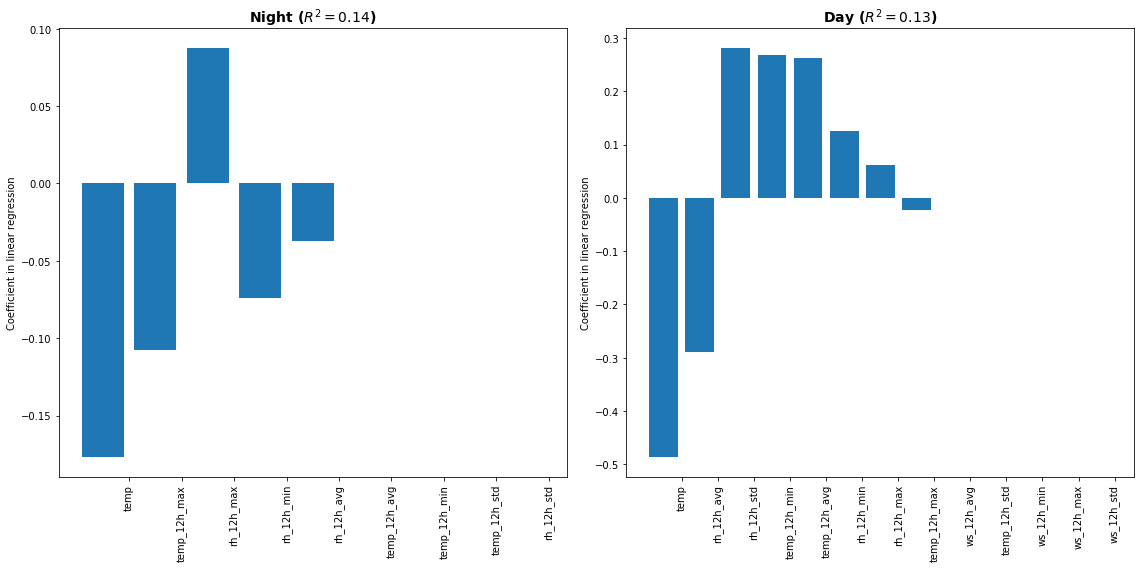

In [50]:
fig=plt.figure(figsize=(16,8))

# getting unzipped lists of feature names and corresponding coefficients, sorted by absolute decreasing coefficient
features_am, weights_am = zip(*sorted(zip(X_am.columns, model_am.coef_), key=lambda x: abs(x[1]), reverse=True))
features_pm, weights_pm = zip(*sorted(zip(X_pm.columns, model_pm.coef_), key=lambda x: abs(x[1]), reverse=True))

ax=fig.add_subplot(1,2,1)
plt.bar(range(len(weights_am)), weights_am)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_am))], features_am, rotation='vertical')
ax.set_title('Night ($R^2=%0.2f$)' % model_am.score(X_am,y_am), {'fontsize': 14, 'fontweight' : 'bold'})

ax=fig.add_subplot(1,2,2)
plt.bar(range(len(weights_pm)), weights_pm)
ax.set_ylabel('Coefficient in linear regression')
plt.xticks([x+0.5 for x in range(len(weights_pm))], features_pm, rotation='vertical')
ax.set_title('Day ($R^2=%0.2f$)' % model_pm.score(X_pm,y_pm), {'fontsize': 14, 'fontweight' : 'bold'}) 

plt.tight_layout()
plt.show()